In [29]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc
import time

In [2]:
import seaborn as sns

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [5]:
# Load the covtype dataset
covtype = fetch_covtype()

In [6]:
# Extract features and target
X = covtype.data
y = covtype.target

In [32]:
y

array([5, 5, 2, ..., 3, 3, 3])

In [7]:
n_features = 20

In [8]:
# Define functions for feature selection and compression
def rfe_feature_selection(X, n_features_to_select):
    # Perform feature selection using RFE
    estimator_rfe = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear')
    rfe = RFE(estimator_rfe, n_features_to_select=n_features_to_select, step=1)
    X_rfe = rfe.fit_transform(X, y)
    return rfe, X_rfe

In [9]:
# Define functions for feature selection and compression
def f_classif_feature_selection(X, k):
    # Perform feature selection using F-classif (SelectKBest)
    fclassif = SelectKBest(score_func=f_classif, k=k)
    X_fclassif = fclassif.fit_transform(X, y)
    return fclassif, X_fclassif

In [10]:
# Define functions for classification after feature selection
def classification_after_feature_selection(X_train, X_test, y_train, y_test, method, selector, n_features=None):
    if method == 'rfe':
        # Perform classification using RFE's feature selection
        X_train_transformed = selector.fit_transform(X_train, y_train)
        X_test_transformed = selector.transform(X_test)
    elif method == 'f_classif':
        if n_features is None:
            raise ValueError("Number of components (n_components) must be specified for F-classif (SelectKBest).")
        # Perform classification using F-classif (SelectKBest)'s feature selection
        fclassif = SelectKBest(score_func=f_classif, k=20)
        X_train_transformed = fclassif.fit_transform(X, y)
    else:
        raise ValueError("Invalid feature selection method specified.")

    # Perform classification using RFE's feature selection OR F-classif (SelectKBest)'s feature selection
    # depends on the selector
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    
    # Train a k-nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_transformed, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test_transformed)
    
    return knn, X_test_transformed

In [11]:
# Define a function to compute and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted (1-7)')
    plt.ylabel('True (1-7)')
    plt.title(title)
    plt.show()

In [13]:
# Define a function to visualize transformed data
def visualize_transformed_data(X_transformed, y, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', s=10)
    plt.colorbar(label='Class')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [14]:
# Start a timer for calculating the elapsed time to perform feature selection for RFE
rfe_start_time = time.time()
# Perform feature selection using RFE
rfe, X_rfe = rfe_feature_selection(X, n_features)
# End timer
rfe_end_time = time.time()
# Compute elapsed time
rfe_elapsed_time = rfe_end_time - rfe_start_time

In [15]:
print("Time taken for RFE's feature selection:", rfe_elapsed_time, "seconds")

Time taken for RFE's feature selection: 704.3306639194489 seconds


In [16]:
# Start a timer for calculating the elapsed time to perform feature selection for F-classif (SelectKBest)
f_classif_start_time = time.time()
# Perform feature selection using F-classif (SelectKBest)
f_classif, X_f_classif = f_classif_feature_selection(X, n_features)
# End timer
f_classif_end_time = time.time()
# Compute elapsed time
f_classif_elapsed_time = f_classif_end_time - f_classif_start_time

In [17]:
print("Time taken for F-classif's feature selection:", f_classif_elapsed_time, "seconds")

Time taken for F-classif's feature selection: 0.7295405864715576 seconds


In [18]:
# Split the data into training and testing sets for RFE-selected features
rfe_X_train, rfe_X_test, rfe_y_train, rfe_y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

In [19]:
# Split the data into training and testing sets for F-classif-selected features
f_classif_X_train, f_classif_X_test, f_classif_y_train, f_classif_y_test = train_test_split(X_f_classif, y, test_size=0.2, random_state=42)

In [20]:
# Perform classification after feature selection for RFE
rfe_knn, rfe_X_test_transformed = classification_after_feature_selection(rfe_X_train, rfe_X_test, rfe_y_train, rfe_y_test, method='rfe', selector=rfe, n_features=n_features)

In [21]:
# Perform classification after feature selection for F-classif (SelectKBest)
f_classif_knn, f_classif_X_test_transformed = classification_after_feature_selection(f_classif_X_train, f_classif_X_test, f_classif_y_train, f_classif_y_test, method='rfe', selector=f_classif, n_features=n_features)

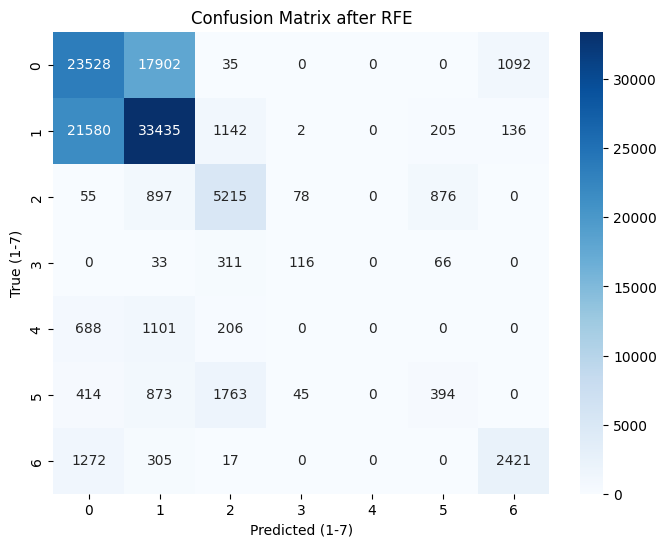

In [22]:
# Compute confusion matrix for RFE, Use pca_knn to make predictions
rfe_y_pred = rfe_knn.predict(rfe_X_test_transformed)
plot_confusion_matrix(rfe_y_test, rfe_y_pred, "Confusion Matrix after RFE")

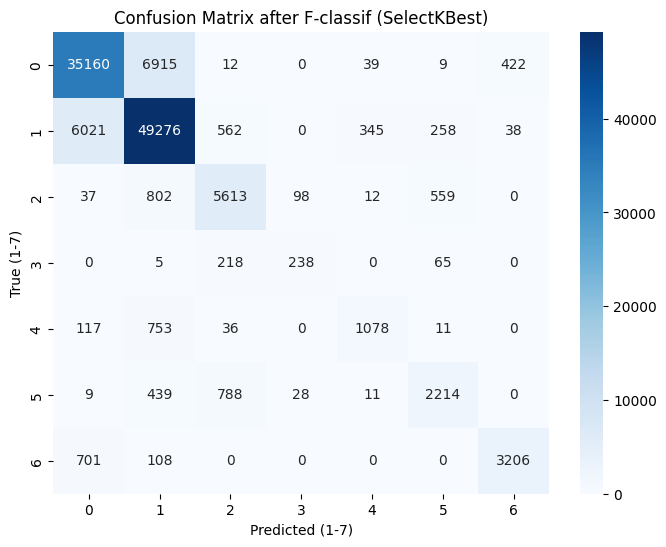

In [23]:
# Compute confusion matrix for F-classif (SelectKBest), Use pca_knn to make predictions
f_classif_y_pred = f_classif_knn.predict(f_classif_X_test_transformed)
plot_confusion_matrix(f_classif_y_test, f_classif_y_pred, "Confusion Matrix after F-classif (SelectKBest)")

In [33]:
# Print classification report
print("Classification Report for RFE:")
rfe_report = classification_report(rfe_y_test, rfe_y_pred, output_dict=True, zero_division=1)

# Access and print desired metrics from the dictionary
for rfe_label, rfe_metrics in rfe_report.items():
    # Check if 'label' is not "accuracy" (the last element)
    if rfe_label != "accuracy" and rfe_label != "macro avg" and rfe_label != "weighted avg":
        print(f"Class {rfe_label}:")
        print(f"\tPrecision: {rfe_metrics['precision']}")
        print(f"\tRecall: {rfe_metrics['recall']}")
        print(f"\tF1-score: {rfe_metrics['f1-score']}")
    elif rfe_label == "accuracy":
        # Handle the accuracy score separately
        print(f"Accuracy: {rfe_metrics}")
    elif rfe_label == "macro avg":
        # Handle the macro avg separately
        print(f"Macro avg:")
        print(f"\tPrecision: {rfe_metrics['precision']}")
        print(f"\tRecall: {rfe_metrics['recall']}")
        print(f"\tF1-score: {rfe_metrics['f1-score']}")
    else:
        # Handle the weighted avg separately
        print(f"Weighted avg:")
        print(f"\tPrecision: {rfe_metrics['precision']}")
        print(f"\tRecall: {rfe_metrics['recall']}")
        print(f"\tF1-score: {rfe_metrics['f1-score']}")

Classification Report for RFE:
Class 1:
	Precision: 0.4949407829690557
	Recall: 0.5528585191625349
	F1-score: 0.5222989322263414
Class 2:
	Precision: 0.6129688703112969
	Recall: 0.5917699115044248
	F1-score: 0.6021828791671919
Class 3:
	Precision: 0.6001841408677638
	Recall: 0.7323409633478444
	F1-score: 0.6597090449082859
Class 4:
	Precision: 0.48132780082987553
	Recall: 0.22053231939163498
	F1-score: 0.30247718383311606
Class 5:
	Precision: 1.0
	Recall: 0.0
	F1-score: 0.0
Class 6:
	Precision: 0.2556781310837119
	Recall: 0.11292633992548008
	F1-score: 0.15666003976143142
Class 7:
	Precision: 0.6634694436832009
	Recall: 0.6029887920298879
	F1-score: 0.6317849686847599
Accuracy: 0.5603039508446426
Macro avg:
	Precision: 0.5869384528207008
	Recall: 0.40191669219454385
	F1-score: 0.4107304355115895
Weighted avg:
	Precision: 0.5660259767776852
	Recall: 0.5603039508446426
	F1-score: 0.5524031476570125


In [34]:
# Print classification report
print("Classification Report for F-classif (SelectKBest):")
f_classif_report = classification_report(f_classif_y_test, f_classif_y_pred, output_dict=True, zero_division=1)

# Access and print desired metrics from the dictionary
for f_classif_label, f_classif_metrics in f_classif_report.items():
    # Check if 'label' is not "accuracy" (the last element)
    if f_classif_label != "accuracy" and f_classif_label != "macro avg" and f_classif_label != "weighted avg":
        print(f"Class {f_classif_label}:")
        print(f"\tPrecision: {f_classif_metrics['precision']}")
        print(f"\tRecall: {f_classif_metrics['recall']}")
        print(f"\tF1-score: {f_classif_metrics['f1-score']}")
    elif f_classif_label == "accuracy":
        # Handle the accuracy score separately
        print(f"Accuracy: {f_classif_metrics}")
    elif f_classif_label == "macro avg":
        # Handle the macro avg separately
        print(f"Macro avg:")
        print(f"\tPrecision: {f_classif_metrics['precision']}")
        print(f"\tRecall: {f_classif_metrics['recall']}")
        print(f"\tF1-score: {f_classif_metrics['f1-score']}")
    else:
        # Handle the weighted avg separately
        print(f"Weighted avg:")
        print(f"\tPrecision: {f_classif_metrics['precision']}")
        print(f"\tRecall: {f_classif_metrics['recall']}")
        print(f"\tF1-score: {f_classif_metrics['f1-score']}")

Classification Report for F-classif (SelectKBest):
Class 1:
	Precision: 0.8362468783446307
	Recall: 0.8261860563479568
	F1-score: 0.8311860239710646
Class 2:
	Precision: 0.8452434045764863
	Recall: 0.872141592920354
	F1-score: 0.8584818550845833
Class 3:
	Precision: 0.776455941347351
	Recall: 0.7882319898890605
	F1-score: 0.7822996515679442
Class 4:
	Precision: 0.6538461538461539
	Recall: 0.4524714828897338
	F1-score: 0.5348314606741573
Class 5:
	Precision: 0.725925925925926
	Recall: 0.5403508771929825
	F1-score: 0.6195402298850575
Class 6:
	Precision: 0.7105263157894737
	Recall: 0.6345657781599312
	F1-score: 0.6704012112036336
Class 7:
	Precision: 0.8745226404800873
	Recall: 0.798505603985056
	F1-score: 0.8347871370915245
Accuracy: 0.8328958804850133
Macro avg:
	Precision: 0.7746810371871584
	Recall: 0.7017790544835821
	F1-score: 0.7330753670682807
Weighted avg:
	Precision: 0.8317851822679341
	Recall: 0.8328958804850133
	F1-score: 0.8317837623940701
